In [1]:
import pandas as pd
import numpy as np
from joblib import dump, load

import matplotlib.pyplot as plt

In [2]:
TRACKMATE_PATH = "/scratch/indikar_root/indikar1/cstansbu/wh18_results/control_myod_only/filtered_spots.csv"
MODEL_PATH = "/scratch/indikar_root/indikar1/cstansbu/wh18_results/model_outputs/model.joblib"
SCALER_PATH = "/scratch/indikar_root/indikar1/cstansbu/wh18_results/model_outputs/scaler.joblib"
TIF_PATH = "/scratch/indikar_root/indikar1/cstansbu/wh18_results/control_myod_only/tiff/"
TRAINNING_COLS = ["MEAN_INTENSITY_RED","MEDIAN_INTENSITY_RED","MIN_INTENSITY_RED","MAX_INTENSITY_RED","TOTAL_INTENSITY_RED","STD_INTENSITY_RED","CONTRAST_RED","SNR_RED","MEAN_INTENSITY_GREEN", "MEDIAN_INTENSITY_GREEN","MIN_INTENSITY_GREEN","MAX_INTENSITY_GREEN","TOTAL_INTENSITY_GREEN","STD_INTENSITY_GREEN","CONTRAST_GREEN","SNR_GREEN","MEAN_INTENSITY_BLUE","MEDIAN_INTENSITY_BLUE","MIN_INTENSITY_BLUE","MAX_INTENSITY_BLUE","TOTAL_INTENSITY_BLUE","STD_INTENSITY_BLUE","CONTRAST_BLUE","SNR_BLUE","RADIUS","ELLIPSE_X0","ELLIPSE_Y0","ELLIPSE_MAJOR", "ELLIPSE_MINOR","ELLIPSE_THETA","ELLIPSE_ASPECTRATIO","AREA","PERIMETER","CIRCULARITY","SOLIDITY"]
RESULTS_PATH = "/scratch/indikar_root/indikar1/cstansbu/wh18_results/results/"
MINUTES_PER_FRAME = 25

In [9]:
%matplotlib inline

In [3]:
def plot_config(size=(5, 5), dpi=200):
    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams['figure.figsize'] = size

In [4]:
def load_model(model_path):
    """A function to load a trained model """
    return load(model_path) 

def load_scaler(scaler_path):
    """A funciton to load a trained scaler"""
    return load(scaler_path) 

def load_trackmate_path(trackmate_path):
    """A function to load FILTERED spots """
    return pd.read_csv(trackmate_path)

def col_renamer(df, str_match, new_name):
    """A function to rename columns with a substrig substitution """
    old_names = [x for x in df.columns if str_match in x]
    new_names = [x.replace(str_match, new_name) for x in old_names]
    rename_dict = dict(zip(old_names, new_names))
    df = df.rename(columns=rename_dict)
    return df

def handle_missing(df, x_columns):
    """A function to replace missing values with the max of the column """
    pd.options.mode.use_inf_as_na = True
    for c in x_columns:
        if df[c].isna().sum() > 0:
            df[c] = np.where(df[c].isna(), df[c].max(), df[c])
    return df

def run_predictions(df, model, scaler, x_columns):
    """Function to run a trained model on a whole dataset """
    target_names = ['G1', 'S', 'G2/M', 'NA']
    states = model.predict(scaler.transform(df[x_columns]))
    states = pd.DataFrame(states)
    states.columns = target_names
    df = df.join(states)
    df['estimate'] = df[target_names].idxmax(axis=1)
    return df
    
def get_condition(df):
    """A function to parse the condition from the filename """
    getCondition = lambda x : x.split("_")[0]
    df['CONDITION'] = df['FILE'].apply(getCondition)
    return df

In [5]:
"""
load all the components
"""
model = load_model(MODEL_PATH)
scaler = load_scaler(SCALER_PATH)

df = load_trackmate_path(TRACKMATE_PATH)

# rename some columns
df = col_renamer(df, 'CH1', 'RED')
df = col_renamer(df, 'CH2', 'GREEN')
df = col_renamer(df, 'CH3', 'BLUE')

df = get_condition(df)

df = handle_missing(df, TRAINNING_COLS)
df = run_predictions(df, model, scaler, TRAINNING_COLS)
df.head()

,POSITION_T,TOTAL_INTENSITY_BLUE,TOTAL_INTENSITY_GREEN,TOTAL_INTENSITY_RED,ELLIPSE_MINOR,TRACK_INDEX,TRACK_START,ELLIPSE_THETA,NUMBER_MERGES,CIRCULARITY,...,FILE,FILE_PATH,STEP,MAX_STEP,CONDITION,G1,S,G2/M,NA,estimate
0,0.000000,17510.0,130255.0,5034.0,5.148630,0.0,0.0,0.947644,0.0,0.657368,...,control_1,/scratch/indikar_root/indikar1/cstansbu/wh18_r...,0,50,control,0,0,0,0,G1
1,1002.033915,19010.0,135924.0,4973.0,5.276551,0.0,0.0,0.862986,0.0,0.677789,...,control_1,/scratch/indikar_root/indikar1/cstansbu/wh18_r...,1,50,control,1,0,0,0,G1
2,2004.067830,17075.0,125128.0,7866.0,4.786177,0.0,0.0,0.796038,0.0,0.730912,...,control_1,/scratch/indikar_root/indikar1/cstansbu/wh18_r...,2,50,control,0,0,0,0,G1
3,3006.101744,19187.0,147579.0,5496.0,4.924870,0.0,0.0,0.771992,0.0,0.675722,...,control_1,/scratch/indikar_root/indikar1/cstansbu/wh18_r...,3,50,control,0,0,0,0,G1
4,4008.135659,19091.0,132808.0,7338.0,4.755241,0.0,0.0,0.815780,0.0,0.667003,...,control_1,/scratch/indikar_root/indikar1/cstansbu/wh18_r...,4,50,control,1,0,0,0,G1


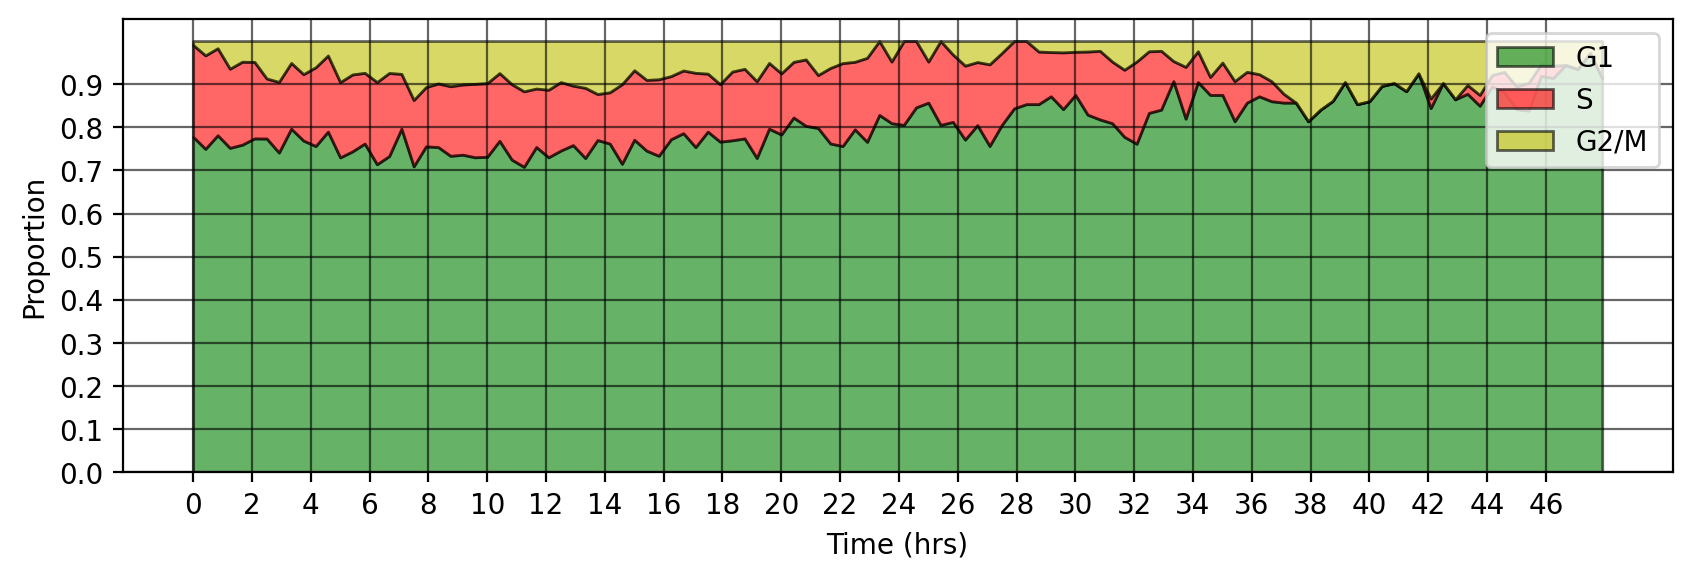

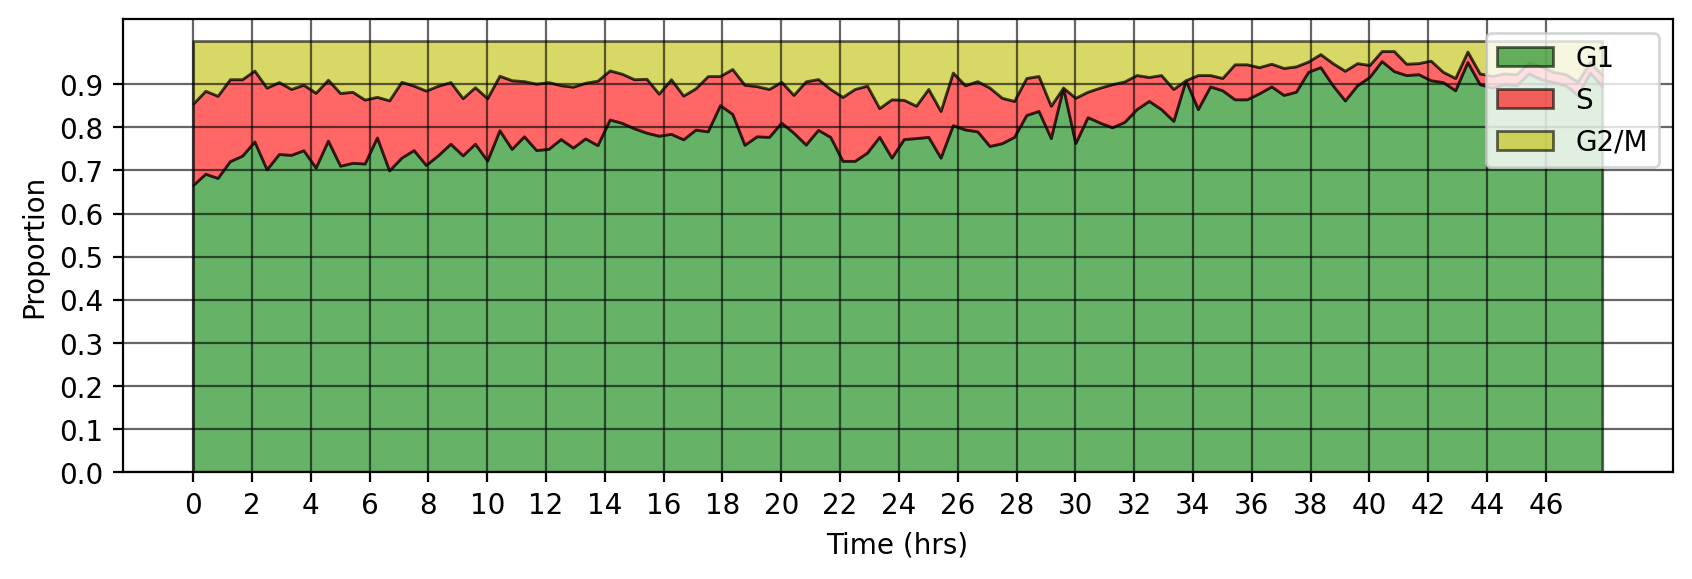

In [20]:
"""
proportion of cells in a given state at a given time
"""

def groupby_time(df, mins_per_frame):
    """A function to return groupby time """
    # groupby frame
    grpedByTime = df.groupby("FRAME").agg(
        count_G1 = ("G1", np.sum),
        count_S = ("S", np.sum),
        count_G2 = ("G2/M", np.sum),
        count_NA = ("NA", np.sum)
    ).reset_index()

    grpedByTime['total'] = grpedByTime[['count_G1', 'count_S', 'count_G2']].sum(axis=1)
    grpedByTime['total_all'] = grpedByTime[['count_G1', 'count_S', 'count_G2', 'count_NA']].sum(axis=1)
    grpedByTime['pG1'] = grpedByTime['count_G1'] / grpedByTime['total']
    grpedByTime['pS'] = grpedByTime['count_S'] / grpedByTime['total']
    grpedByTime['pG2'] = grpedByTime['count_G2'] / grpedByTime['total']
    grpedByTime['Time'] = (grpedByTime['FRAME'] * mins_per_frame) / 60
    return grpedByTime
    

def proportion_plot(df, outpath, show=True):
    """A function to generate a proportion plot"""
    stack = [df['pG1'], df['pS'], df['pG2']]
    plt.stackplot(df['Time'], stack, 
          labels=['G1','S','G2/M'], 
          colors=['g', 'r', 'y'],
          edgecolor='k',
          alpha=0.6)
    
    ax = plt.gca()
    
    ax.set_xticks(np.arange(0, df['Time'].max(), 2))
    ax.set_yticks(np.arange(0, 1., 0.1))
    plt.grid(color='k', alpha=0.6)
    plt.legend(loc='upper right')
    plt.xlabel("Time (hrs)")
    plt.ylabel("Proportion")
    
    plt.savefig(outpath, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()


for c in df['CONDITION'].unique():
    condFrame = df[df['CONDITION'] == c]
    grpedByTime = groupby_time(condFrame, MINUTES_PER_FRAME)
    plot_config(size=(10, 3))
    
    outpath = f"{RESULTS_PATH}{c}_proportion_plot.png"
    proportion_plot(grpedByTime, outpath)    

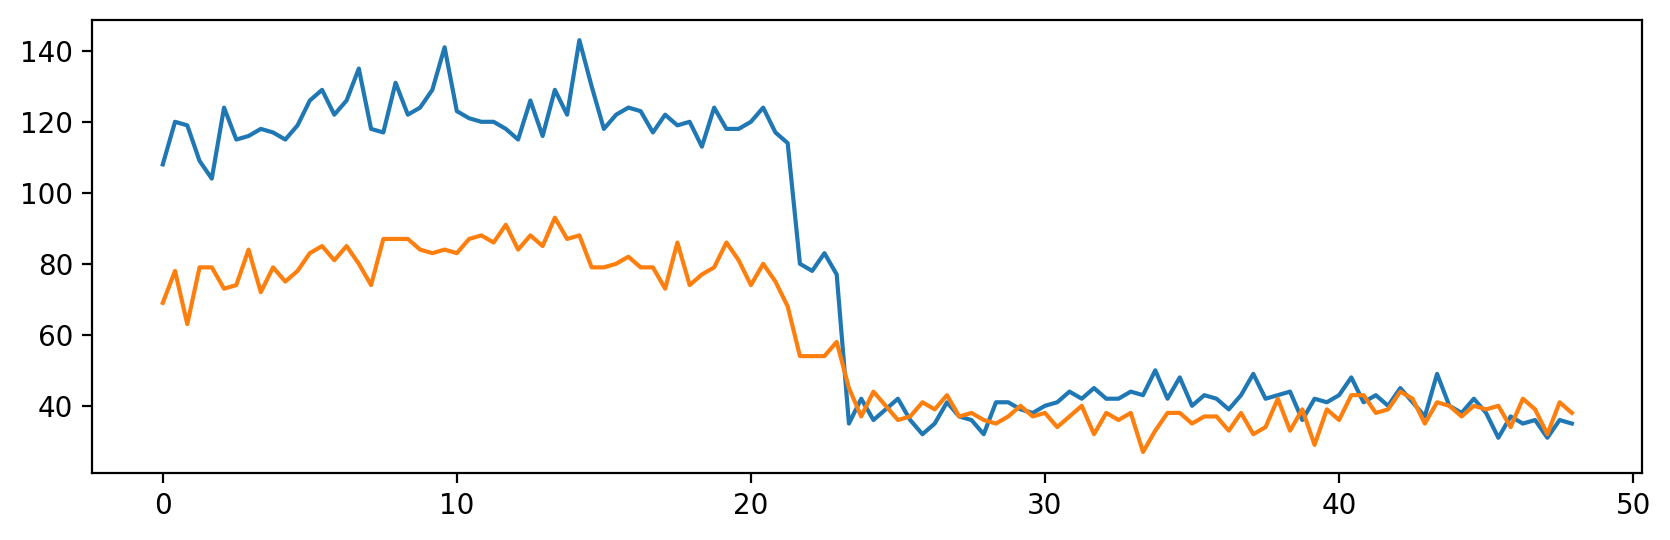

In [24]:
"""
growth by condition
"""

def growth_by_condition_plot(df, outpath):
    """A function to plot population changes over time by condition """
    
    for c in df['CONDITION'].unique():
        condFrame = df[df['CONDITION'] == c]
        grpedByTime = groupby_time(condFrame, MINUTES_PER_FRAME)
        
        plt.plot(grpedByTime['Time'], grpedByTime['total'])
        
        


growth_by_condition_plot(df, "")